In [2]:
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import json
from typing import Union, List
import matplotlib.patches as mpatches
import scipy.stats as stats
import numpy as np
from scipy.stats import shapiro
import math
import matplotlib.ticker as ticker
import plotly.express as px

sns.set_palette("pastel")


## 1. Laden der Datensätze

### 1.1 Utility Functions

In [3]:
def get_answer_text(question_code: str, answer_res: Union[float, int, str] = None):
    if isinstance(answer_res, str):
        _res = answer_res
    else:
        _res = int(answer_res) if answer_res != 0 else '<leer>'
    t_code = df_code[df_code["Variable"] == question_code]
    question_type = t_code["Fragetyp"].values[0]
    assert (answer_res is not None and question_type != 'Offene Frage') or (answer_res is None and question_type == 'Offene Frage'), f"Ungültige Antwortmöglichkeit für Fragentyp {question_type}"
    answer_dict = t_code["Werte"].values[0]
    out = answer_dict[str(_res)] if answer_res is not None else answer_dict
    return out

In [73]:
def add_new_line(i_str: str):
    lines = i_str.split(" ")
    print(lines)
    if len(lines) > 1:
        return " ".join(lines[:3]) + "\n" + " ".join(lines[3:])
    else:
        return lines[0]

In [74]:
add_new_line("4.5 Flache Hierarchien (auf Augenhöhe miteinander arbeiten)")

['4.5', 'Flache', 'Hierarchien', '(auf', 'Augenhöhe', 'miteinander', 'arbeiten)']


'4.5 Flache Hierarchien\n(auf Augenhöhe miteinander arbeiten)'

In [4]:
def get_question_text(question_code: str):
    return df_code[df_code["Variable"] == question_code]["Fragetext"].values[0]

### 1.2 Gliederung der Fragetypen

In [12]:
skala_ids = df_code[df_code["Fragetyp"] == "Skalafrage"]["Variable"].tolist()
one_of_n_ids = df_code[df_code["Fragetyp"] == "1 aus n"]["Variable"].tolist()
numeric_ids = skala_ids + one_of_n_ids
open_q_ids = df_code[df_code["Fragetyp"] == "Offene Frage"]["Variable"].tolist()

In [13]:
generation_col = '60371649'
gender_col = '60371650'
academic_col = '60371651'
working_col = '60371652'
work_form_col = '60371653'
economic_sector_col = '60371654'

In [14]:
skala_fach_ids = [x for x in skala_ids if int(x) <= 60371648]
one_of_n_fach_ids = [x for x in one_of_n_ids if int(x) <= 60371648]
num_fach_cols = skala_fach_ids + one_of_n_fach_ids

print(skala_fach_ids)
print(one_of_n_fach_ids)

['60371597', '60371598', '60371599', '60371600', '60371601', '60371602', '60371603', '60371604', '60371605', '60371606', '60371607', '60371608', '60371609', '60371615', '60371616', '60371617', '60371618', '60371619', '60371620', '60371624', '60371625', '60371626', '60371627', '60371628', '60371629', '60371630', '60371631', '60371632', '60371633', '60371634', '60371635', '60371636', '60371637', '60371638', '60371639', '60371640', '60371641', '60371642', '60371643', '60371644', '60371645', '60371646', '60371647', '60371648']
['60371613', '60371614']


In [91]:
erwartungen_ids = [x for x in codes if 60371597 <= int(x) and int(x) <= 60371609]
ag_merkmale_ids = [x for x in codes if 60371615 <= int(x) and int(x) <= 60371620]
print(erwartungen_ids)

['60371597', '60371598', '60371599', '60371600', '60371601', '60371602', '60371603', '60371604', '60371605', '60371606', '60371607', '60371608', '60371609']


In [269]:
werte_ids = [x for x in codes if 60371624 <= int(x) and int(x) <= 60371648]
familie_ids = [60371641, 60371640, 60371634, 60371635, 60371638, 60371645]
leben_ids = [60371643, 60371646, 60371644, 60371642, 60371647, 60371648]
tugend_ids = [60371624, 60371628, 60371631, 60371638]
toleranz_ids = [60371633, 60371629, 60371632, 60371648, 60371627]
macht_ids = ["60371626", "60371625", "60371630", "60371642"]
tradition_ids = [60371637, 60371639, 60371636]

print(werte_ids)

['60371624', '60371625', '60371626', '60371627', '60371628', '60371629', '60371630', '60371631', '60371632', '60371633', '60371634', '60371635', '60371636', '60371637', '60371638', '60371639', '60371640', '60371641', '60371642', '60371643', '60371644', '60371645', '60371646', '60371647', '60371648']


### 1.3 Daten

In [7]:
results_pre_processed = pq.read_table('results_preprocessed.parquet')

In [8]:
df_yz = results_pre_processed.to_pandas()

In [9]:
df_yz.head()

,Bogen,60371597,60371598,60371599,60371600,60371601,60371602,60371603,60371604,60371605,...,60371647,60371648,60371649,60371650,60371651,60371652,60371653,60371654,Zeitstempel,Datensatz-Ursprung
0,1,4,4,5,4,4,5,5,4,4,...,2,5,2,2.0,6,1,1.0,3.0,02.07.2023 um 17:44:14,O
1,2,4,5,5,5,5,4,5,4,4,...,1,5,1,2.0,6,1,1.0,2.0,02.07.2023 um 17:50:50,O
2,3,4,2,5,4,5,4,5,2,4,...,2,3,1,1.0,4,1,1.0,3.0,02.07.2023 um 18:55:10,M
3,4,5,4,5,4,4,4,4,2,3,...,1,5,1,2.0,4,1,2.0,3.0,02.07.2023 um 19:00:41,M
4,5,5,4,5,3,5,5,4,3,4,...,1,4,1,2.0,5,1,1.0,3.0,02.07.2023 um 19:03:32,M


In [10]:
with open('code.json', 'r') as f:
  code_data = json.load(f)

In [11]:
df_code = pd.DataFrame(code_data)
codes = df_code["Variable"].tolist()

## 2. Deskriptive Beschreibung der Stichproben Gesamtheit

In [17]:
desc = df_yz.describe()
display(desc)

,Bogen,60371597,60371598,60371599,60371600,60371601,60371602,60371603,60371604,60371605,...,60371645,60371646,60371647,60371648,60371649,60371650,60371651,60371652,60371653,60371654
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000,200.00000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.0000,200.000000,200.000000
mean,112.595000,3.990000,3.660000,4.485000,3.655000,4.695000,4.180000,4.17000,3.205000,3.86000,...,4.080000,3.105000,1.810000,4.270000,1.460000,1.580000,4.955000,1.0900,1.210000,2.405000
std,67.286987,0.593008,0.958642,0.743329,0.932913,0.482846,0.741857,0.77076,1.126642,0.86843,...,0.785292,0.989378,1.149131,0.866518,0.499648,0.504851,1.187445,0.2869,0.705969,0.962083
min,1.000000,2.000000,1.000000,1.000000,1.000000,3.000000,2.000000,1.00000,1.000000,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.0000,0.000000,0.000000
25%,52.750000,4.000000,3.000000,4.000000,3.000000,4.000000,4.000000,4.00000,2.000000,3.00000,...,4.000000,2.000000,1.000000,4.000000,1.000000,1.000000,4.000000,1.0000,1.000000,2.000000
50%,111.500000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,4.00000,3.000000,4.00000,...,4.000000,3.000000,1.000000,4.000000,1.000000,2.000000,5.000000,1.0000,1.000000,3.000000
75%,172.500000,4.000000,4.000000,5.000000,4.000000,5.000000,5.000000,5.00000,4.000000,4.00000,...,5.000000,4.000000,2.000000,5.000000,2.000000,2.000000,6.000000,1.0000,2.000000,3.000000
max,227.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.00000,...,5.000000,5.000000,5.000000,5.000000,2.000000,3.000000,6.000000,2.0000,4.000000,3.000000


In [18]:
desc_y = df_yz[df_yz[generation_col]==1].describe()
display(desc_y)

,Bogen,60371597,60371598,60371599,60371600,60371601,60371602,60371603,60371604,60371605,...,60371645,60371646,60371647,60371648,60371649,60371650,60371651,60371652,60371653,60371654
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,...,108.000000,108.000000,108.000000,108.000000,108.0,108.000000,108.000000,108.000000,108.000000,108.000000
mean,89.037037,4.027778,3.518519,4.416667,3.583333,4.601852,4.037037,4.074074,3.018519,3.833333,...,3.981481,3.111111,1.703704,4.138889,1.0,1.472222,5.129630,1.018519,1.333333,2.546296
std,57.690914,0.603081,0.980954,0.737830,0.958240,0.510448,0.819459,0.839489,1.110540,0.870063,...,0.808616,0.979542,1.193904,0.941845,0.0,0.501555,1.160829,0.135445,0.641260,0.753611
min,2.000000,2.000000,1.000000,2.000000,1.000000,3.000000,2.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,2.000000,1.000000,0.000000,0.000000
25%,44.750000,4.000000,3.000000,4.000000,3.000000,4.000000,4.000000,4.000000,2.000000,4.000000,...,4.000000,2.000000,1.000000,4.000000,1.0,1.000000,4.000000,1.000000,1.000000,2.000000
50%,81.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,4.000000,3.000000,4.000000,...,4.000000,3.000000,1.000000,4.000000,1.0,1.000000,6.000000,1.000000,1.000000,3.000000
75%,119.500000,4.000000,4.000000,5.000000,4.000000,5.000000,5.000000,5.000000,4.000000,4.000000,...,4.250000,4.000000,2.000000,5.000000,1.0,2.000000,6.000000,1.000000,2.000000,3.000000
max,225.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,1.0,2.000000,6.000000,2.000000,4.000000,3.000000


In [19]:
desc_z = df_yz[df_yz[generation_col]==2].describe()
display(desc_z)

,Bogen,60371597,60371598,60371599,60371600,60371601,60371602,60371603,60371604,60371605,...,60371645,60371646,60371647,60371648,60371649,60371650,60371651,60371652,60371653,60371654
count,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,...,92.000000,92.000000,92.000000,92.000000,92.0,92.000000,92.000000,92.000000,92.000000,92.00000
mean,140.250000,3.945652,3.826087,4.565217,3.739130,4.804348,4.347826,4.282609,3.423913,3.891304,...,4.195652,3.097826,1.934783,4.423913,2.0,1.706522,4.750000,1.173913,1.065217,2.23913
std,67.495157,0.581097,0.909156,0.745748,0.900178,0.425535,0.601003,0.668377,1.111713,0.870222,...,0.744786,1.006133,1.087434,0.744706,0.0,0.481254,1.191776,0.381112,0.753079,1.14229
min,1.000000,2.000000,1.000000,1.000000,1.000000,3.000000,3.000000,2.000000,1.000000,2.000000,...,2.000000,1.000000,1.000000,1.000000,2.0,1.000000,2.000000,1.000000,0.000000,0.00000
25%,106.750000,4.000000,3.000000,4.000000,3.000000,5.000000,4.000000,4.000000,3.000000,3.000000,...,4.000000,2.000000,1.000000,4.000000,2.0,1.000000,4.000000,1.000000,1.000000,2.00000
50%,157.500000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,3.000000,2.000000,5.000000,2.0,2.000000,5.000000,1.000000,1.000000,3.00000
75%,192.250000,4.000000,4.000000,5.000000,4.000000,5.000000,5.000000,5.000000,4.000000,4.250000,...,5.000000,4.000000,3.000000,5.000000,2.0,2.000000,6.000000,1.000000,1.000000,3.00000
max,227.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,2.0,3.000000,6.000000,2.000000,3.000000,3.00000


In [20]:
desc.to_excel("result_description.xlsx")
desc_y.to_excel("result_description_gen_y.xlsx")
desc_z.to_excel("result_description_gen_z.xlsx")

### 2.1 Auswertung der Grundgesamtheit

In [21]:
df_yz_count = df_yz[df_yz.columns.difference(['Bogen', 'Zeitstempel', 'Datensatz-Ursprung'])].apply(lambda x: x.value_counts()).T.stack()
df_yz_percentage = df_yz[df_yz.columns.difference(['Bogen', 'Zeitstempel', 'Datensatz-Ursprung'])].apply(lambda x: x.value_counts(normalize=True)).T.stack()

In [22]:
df_y = df_yz[df_yz[generation_col]==1]
df_z = df_yz[df_yz[generation_col]==2]

In [23]:
df_y_count = df_y[df_y.columns.difference(['Bogen', 'Zeitstempel', 'Datensatz-Ursprung'])].apply(lambda x: x.value_counts()).T.stack()
df_y_percentage = df_y[df_y.columns.difference(['Bogen', 'Zeitstempel', 'Datensatz-Ursprung'])].apply(lambda x: x.value_counts(normalize=True)).T.stack()

df_z_count = df_z[df_z.columns.difference(['Bogen', 'Zeitstempel', 'Datensatz-Ursprung'])].apply(lambda x: x.value_counts()).T.stack()
df_z_percentage = df_z[df_z.columns.difference(['Bogen', 'Zeitstempel', 'Datensatz-Ursprung'])].apply(lambda x: x.value_counts(normalize=True)).T.stack()

In [24]:
df_out = pd.concat([df_yz_count, df_yz_percentage, df_y_count, df_y_percentage, df_z_count, df_z_percentage], axis=1)
df_out = df_out.rename(columns={0: "Anzahl Gesamt", 1: "Anteil Gesamt", 2: "Anzahl Generation Y", 3: "Anteil Generation Y", 4: "Anzahl Generation Z", 5: "Anteil Generation Z"})

In [25]:
df_out.head()

Anzahl Gesamt  Anteil Gesamt  Anzahl Generation Y  \
60371597 2            7.0          0.035                  3.0   
         3           15.0          0.075                  9.0   
         4          151.0          0.755                 78.0   
         5           27.0          0.135                 18.0   
60371598 1            3.0          0.015                  2.0   

            Anteil Generation Y  Anzahl Generation Z  Anteil Generation Z  
60371597 2             0.027778                  4.0             0.043478  
         3             0.083333                  6.0             0.065217  
         4             0.722222                 73.0             0.793478  
         5             0.166667                  9.0             0.097826  
60371598 1             0.018519                  1.0             0.010870

In [ ]:
df_out.to_excel("results_wo_missing.xlsx") 

### 2.2 Auswertung der Durchschnitte

In [26]:
mean_z=df_yz[df_yz[generation_col]==2].mean(numeric_only=True)
mean_y=df_yz[df_yz[generation_col]==1].mean(numeric_only=True)

df_mean = pd.concat([mean_y, mean_z], axis=1)
df_mean["mean_diff"] = df_mean[0] - df_mean[1]
df_mean["mean_diff_abs"] = abs(df_mean[0] - df_mean[1])

In [27]:
df_mean.sort_values(by=['mean_diff'])
df_mean = df_mean.rename(columns={0: "gen_y", 1: "gen_z"})
display(df_mean)

,gen_y,gen_z,mean_diff,mean_diff_abs
Bogen,89.037037,140.250000,-51.212963,51.212963
60371597,4.027778,3.945652,0.082126,0.082126
60371598,3.518519,3.826087,-0.307568,0.307568
60371599,4.416667,4.565217,-0.148551,0.148551
60371600,3.583333,3.739130,-0.155797,0.155797
60371601,4.601852,4.804348,-0.202496,0.202496
60371602,4.037037,4.347826,-0.310789,0.310789
60371603,4.074074,4.282609,-0.208535,0.208535
60371604,3.018519,3.423913,-0.405395,0.405395
60371605,3.833333,3.891304,-0.057971,0.057971


In [28]:
df_mean.to_excel("result_mean_diff.xlsx")

In [29]:
df_mean = df_mean.drop('Bogen')

In [30]:
df_mean_werte = df_mean.filter(items=werte_ids, axis=0)

In [31]:
df_mean_erwartungen = df_mean.filter(items=erwartungen_ids, axis=0)

In [32]:
np.arange(len(df_mean_werte.index)) * 2

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48])

In [33]:
np.arange(len(df_mean_werte.index)) * 2 + 0.5

array([ 0.5,  2.5,  4.5,  6.5,  8.5, 10.5, 12.5, 14.5, 16.5, 18.5, 20.5,
       22.5, 24.5, 26.5, 28.5, 30.5, 32.5, 34.5, 36.5, 38.5, 40.5, 42.5,
       44.5, 46.5, 48.5])

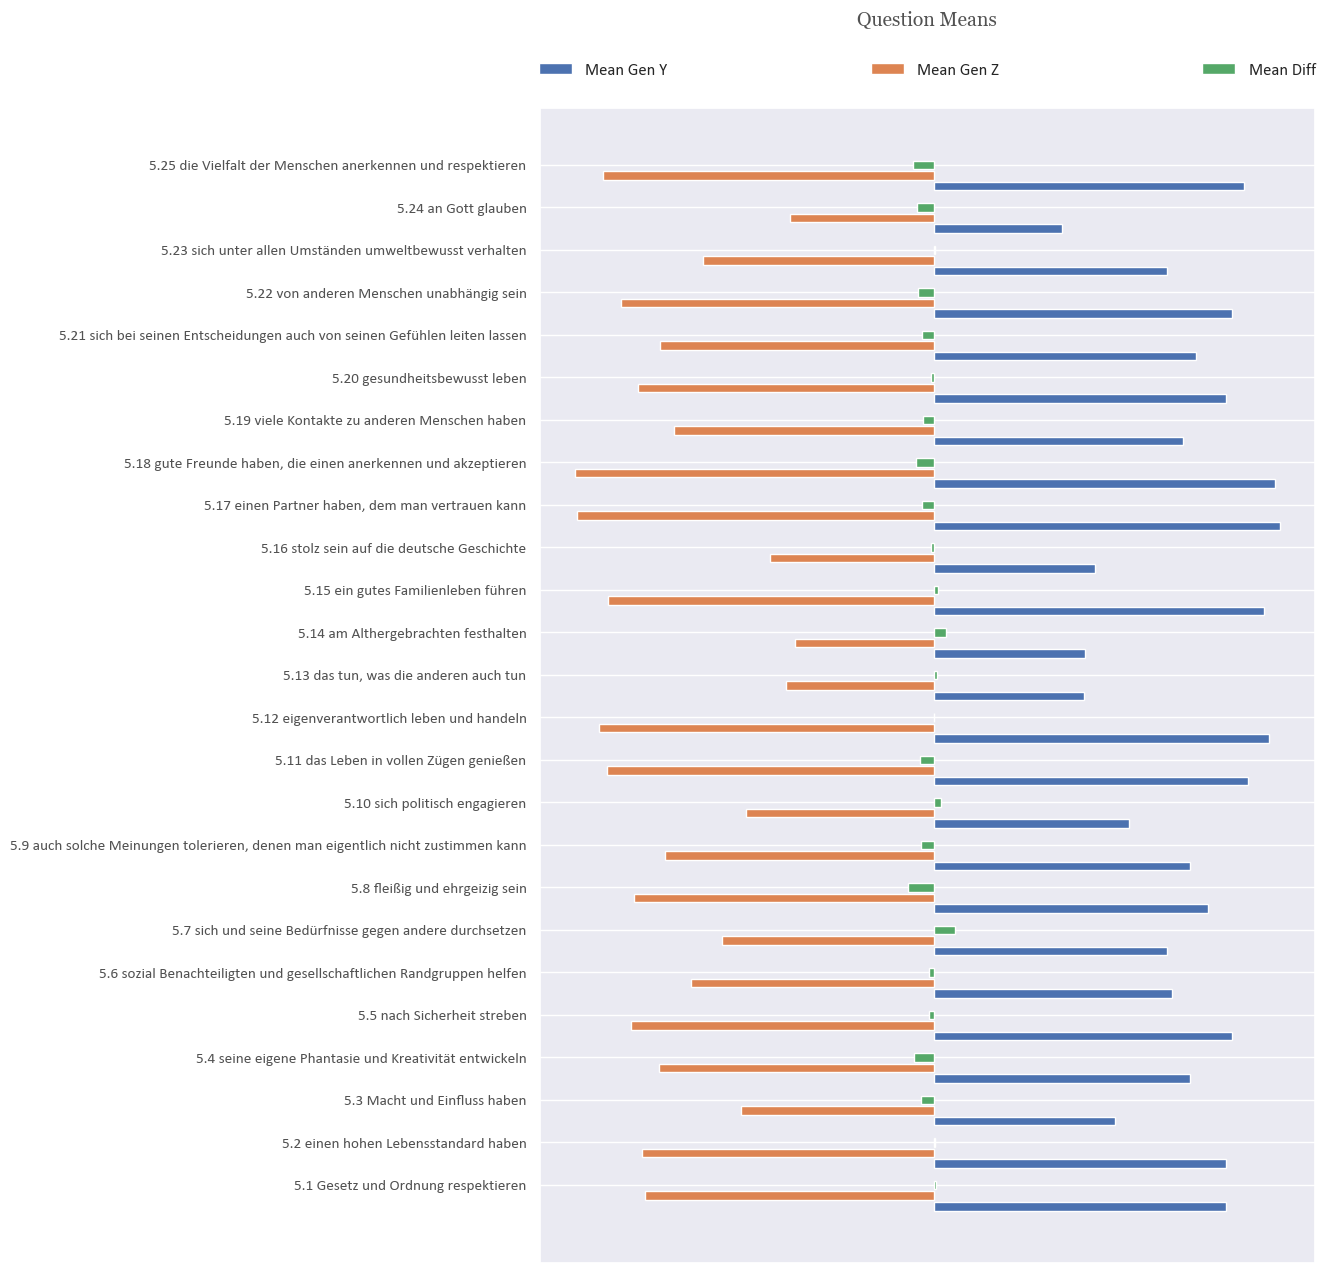

In [36]:
fig, ax = plt.subplots(figsize=(10, 15))

font_color = '#525252'
csfont = {'fontname':'Georgia'} # title font
hfont = {'fontname':'Calibri'} # main font
colors = ['#f47e7a', '#b71f5c', '#621237', '#dbbaa7', '#df4382', '#c58f71']

sns.set()

title = plt.title("Question Means", pad=60, fontsize=14, color=font_color, **csfont)

y_pos_y = np.arange(len(df_mean_werte.index)) * 4

y_pos_z = np.arange(len(df_mean_werte.index)) * 4 + 1

y_pos_diff = np.arange(len(df_mean_werte.index)) * 4 + 2

ax.barh(y_pos_y, df_mean_werte["gen_y"], align='center', label="Mean Gen Y")
ax.barh(y_pos_z, -1 * df_mean_werte["gen_z"], align='center', label="Mean Gen Z")
ax.barh(y_pos_diff, df_mean_werte["mean_diff"], align='center', label="Mean Diff")

plt.xticks(color=font_color, **hfont)
plt.yticks(color=font_color, **hfont)

ax.axes.get_xaxis().set_visible(False)
ax.set_yticks(y_pos_diff, labels=[get_question_text(code) for code in df_mean_werte.index])

legend = plt.legend(loc='center',
           frameon=False,
           bbox_to_anchor=(0., .982, 1., .102), 
           mode='expand', 
           ncol=3, 
           borderaxespad=-.46,
           prop={'size': 12, 'family':'Calibri'})

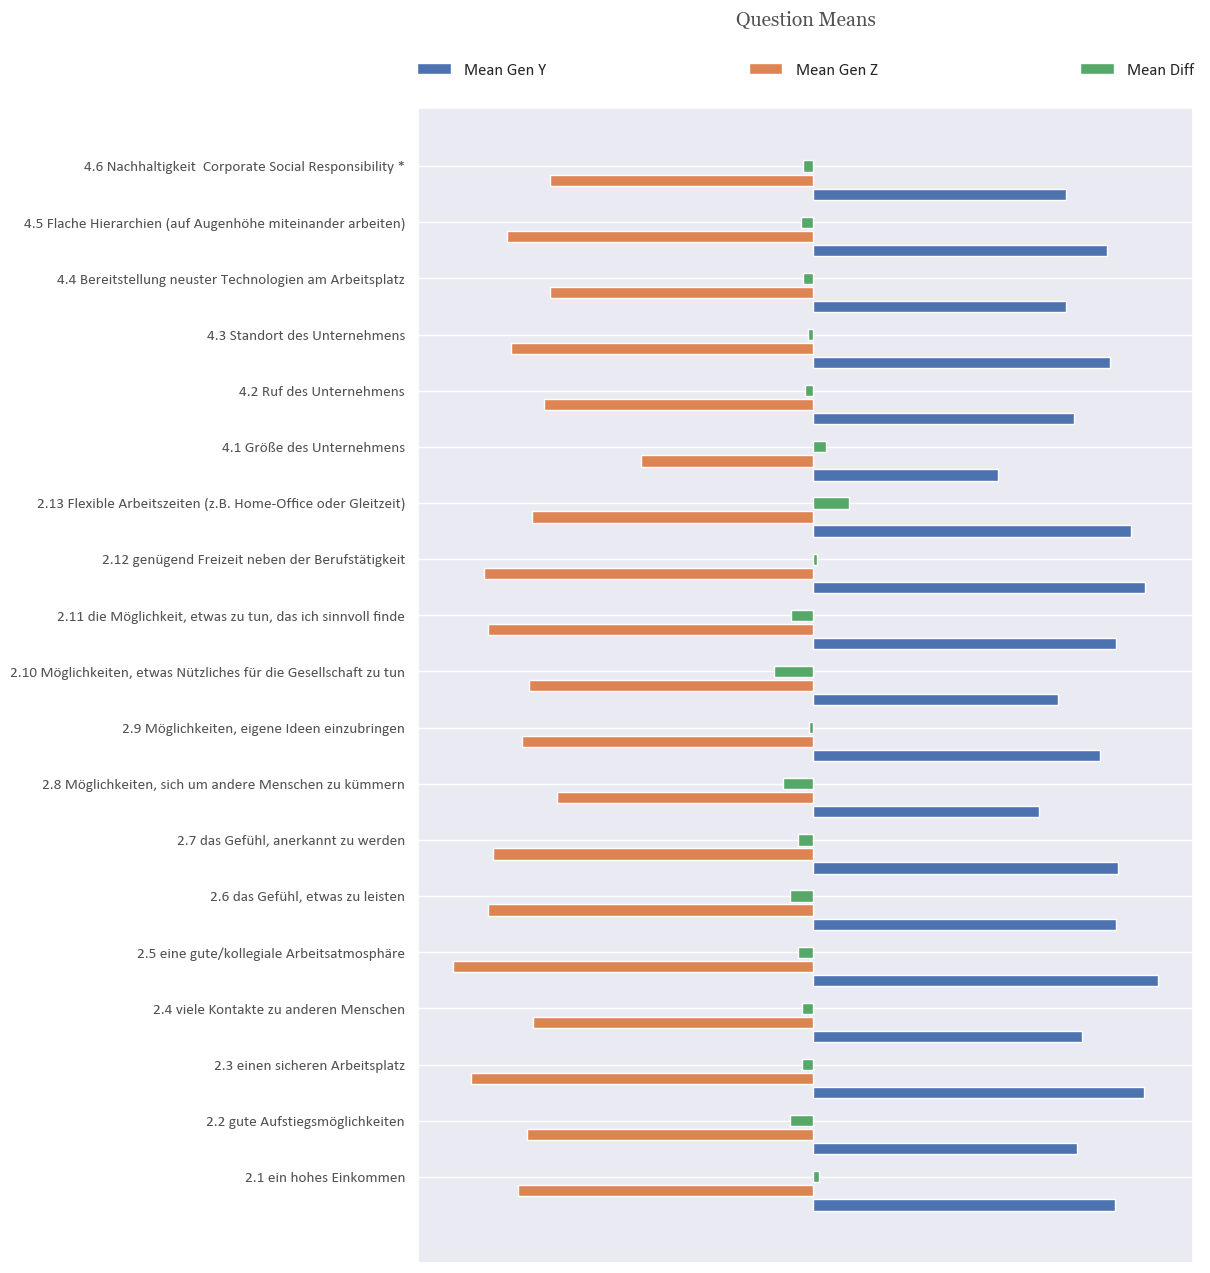

In [35]:
fig, ax = plt.subplots(figsize=(10, 15))

font_color = '#525252'
csfont = {'fontname':'Georgia'} # title font
hfont = {'fontname':'Calibri'} # main font
colors = ['#f47e7a', '#b71f5c', '#621237', '#dbbaa7', '#df4382', '#c58f71']

sns.set()

title = plt.title("Question Means", pad=60, fontsize=14, color=font_color, **csfont)

y_pos_y = np.arange(len(df_mean_erwartungen.index)) * 4

y_pos_z = np.arange(len(df_mean_erwartungen.index)) * 4 + 1

y_pos_diff = np.arange(len(df_mean_erwartungen.index)) * 4 + 2

ax.barh(y_pos_y, df_mean_erwartungen["gen_y"], align='center', label="Mean Gen Y")
ax.barh(y_pos_z, -1 * df_mean_erwartungen["gen_z"], align='center', label="Mean Gen Z")
ax.barh(y_pos_diff, df_mean_erwartungen["mean_diff"], align='center', label="Mean Diff")

plt.xticks(color=font_color, **hfont)
plt.yticks(color=font_color, **hfont)

ax.axes.get_xaxis().set_visible(False)
ax.set_yticks(y_pos_diff, labels=[get_question_text(code) for code in df_mean_erwartungen.index])

legend = plt.legend(loc='center',
           frameon=False,
           bbox_to_anchor=(0., .982, 1., .102), 
           mode='expand', 
           ncol=3, 
           borderaxespad=-.46,
           prop={'size': 12, 'family':'Calibri'})

In [ ]:
fig, ax = plt.subplots(figsize=(10, 15))

font_color = '#525252'
csfont = {'fontname':'Georgia'} # title font
hfont = {'fontname':'Calibri'} # main font
colors = ['#f47e7a', '#b71f5c', '#621237', '#dbbaa7', '#df4382', '#c58f71']

sns.set()

title = plt.title("Question Means", pad=60, fontsize=14, color=font_color, **csfont)

y_pos_y = np.arange(len(df_mean_erwartungen.index)) * 4

y_pos_z = np.arange(len(df_mean_erwartungen.index)) * 4 + 1

y_pos_diff = np.arange(len(df_mean_erwartungen.index)) * 4 + 2

ax.barh(y_pos_y, df_mean_erwartungen["gen_y"], align='center', label="Mean Gen Y")
ax.barh(y_pos_z, -1 * df_mean_erwartungen["gen_z"], align='center', label="Mean Gen Z")
ax.barh(y_pos_diff, df_mean_erwartungen["mean_diff"], align='center', label="Mean Diff")

plt.xticks(color=font_color, **hfont)
plt.yticks(color=font_color, **hfont)

ax.axes.get_xaxis().set_visible(False)
ax.set_yticks(y_pos_diff, labels=[get_question_text(code) for code in df_mean_erwartungen.index])

legend = plt.legend(loc='center',
           frameon=False,
           bbox_to_anchor=(0., .982, 1., .102), 
           mode='expand', 
           ncol=3, 
           borderaxespad=-.46,
           prop={'size': 12, 'family':'Calibri'})

### 2.3 Visualisierung der Grundgesamtheit

In [37]:
gen_count = df_yz[generation_col].value_counts()
print(gen_count)

60371649
1    108
2     92
Name: count, dtype: int64


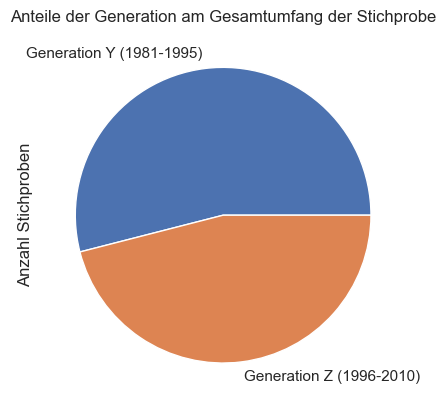

In [38]:
fig = gen_count.plot(kind='pie', labels=["Generation Y (1981-1995)", "Generation Z (1996-2010)", "Andere Generation"])
plt.ylabel("Anzahl Stichproben")
plt.title("Anteile der Generation am Gesamtumfang der Stichprobe")
plt.show(fig)

In [271]:
def transpose_count(count_df, index_str):
    count_df.columns = count_df.iloc[0]
    count_df.drop(count_df.index[0], inplace=True)
    count_df.rename(index={'proportion':index_str}, inplace=True)
    return count_df

def get_count_df(input_df, question_code):
    temp_y = input_df[question_code][input_df[generation_col] == 1].value_counts(normalize=True).reset_index().T
    temp_z = input_df[question_code][input_df[generation_col] == 2].value_counts(normalize=True).reset_index().T
    out_df = pd.concat([pd.DataFrame(columns=[0,1,2,3,4,5]), transpose_count(temp_y, 'Gen Y'), transpose_count(temp_z, 'Gen Z')])
    out_df.fillna(0, inplace=True)
    out_df = out_df.round(10)
    out_df.rename(columns={col: int(col) for col in out_df.columns}, inplace=True)
    #out_df['sum'] = out_df[list(out_df.columns)].sum(axis=1)
    return out_df

In [268]:
get_count_df(df_yz, "60371626")

,0,1,2,3,4,5,sum
Gen Y,0,0.166667,0.379630,0.361111,0.055556,0.037037,1.0
Gen Z,0,0.130435,0.336957,0.358696,0.163043,0.010870,1.0


#### 2.3.1 Darstellung Umfrageergebnisse - Erwartungen an die Beschäftigung

['2.1', 'ein', 'hohes', 'Einkommen']
['2.2', 'gute', 'Aufstiegsmöglichkeiten']
['2.3', 'einen', 'sicheren', 'Arbeitsplatz']
['2.4', 'viele', 'Kontakte', 'zu', 'anderen', 'Menschen']
['2.5', 'eine', 'gute/kollegiale', 'Arbeitsatmosphäre']
['2.6', 'das', 'Gefühl,', 'etwas', 'zu', 'leisten']
['2.7', 'das', 'Gefühl,', 'anerkannt', 'zu', 'werden']
['2.8', 'Möglichkeiten,', 'sich', 'um', 'andere', 'Menschen', 'zu', 'kümmern']
['2.9', 'Möglichkeiten,', 'eigene', 'Ideen', 'einzubringen']
['2.10', 'Möglichkeiten,', 'etwas', 'Nützliches', 'für', 'die', 'Gesellschaft', 'zu', 'tun']
['2.11', 'die', 'Möglichkeit,', 'etwas', 'zu', 'tun,', 'das', 'ich', 'sinnvoll', 'ﬁnde']
['2.12', 'genügend', 'Freizeit', 'neben', 'der', 'Berufstätigkeit']
['2.13', 'Flexible', 'Arbeitszeiten', '(z.B.', 'Home-Ofﬁce', 'oder', 'Gleitzeit)']


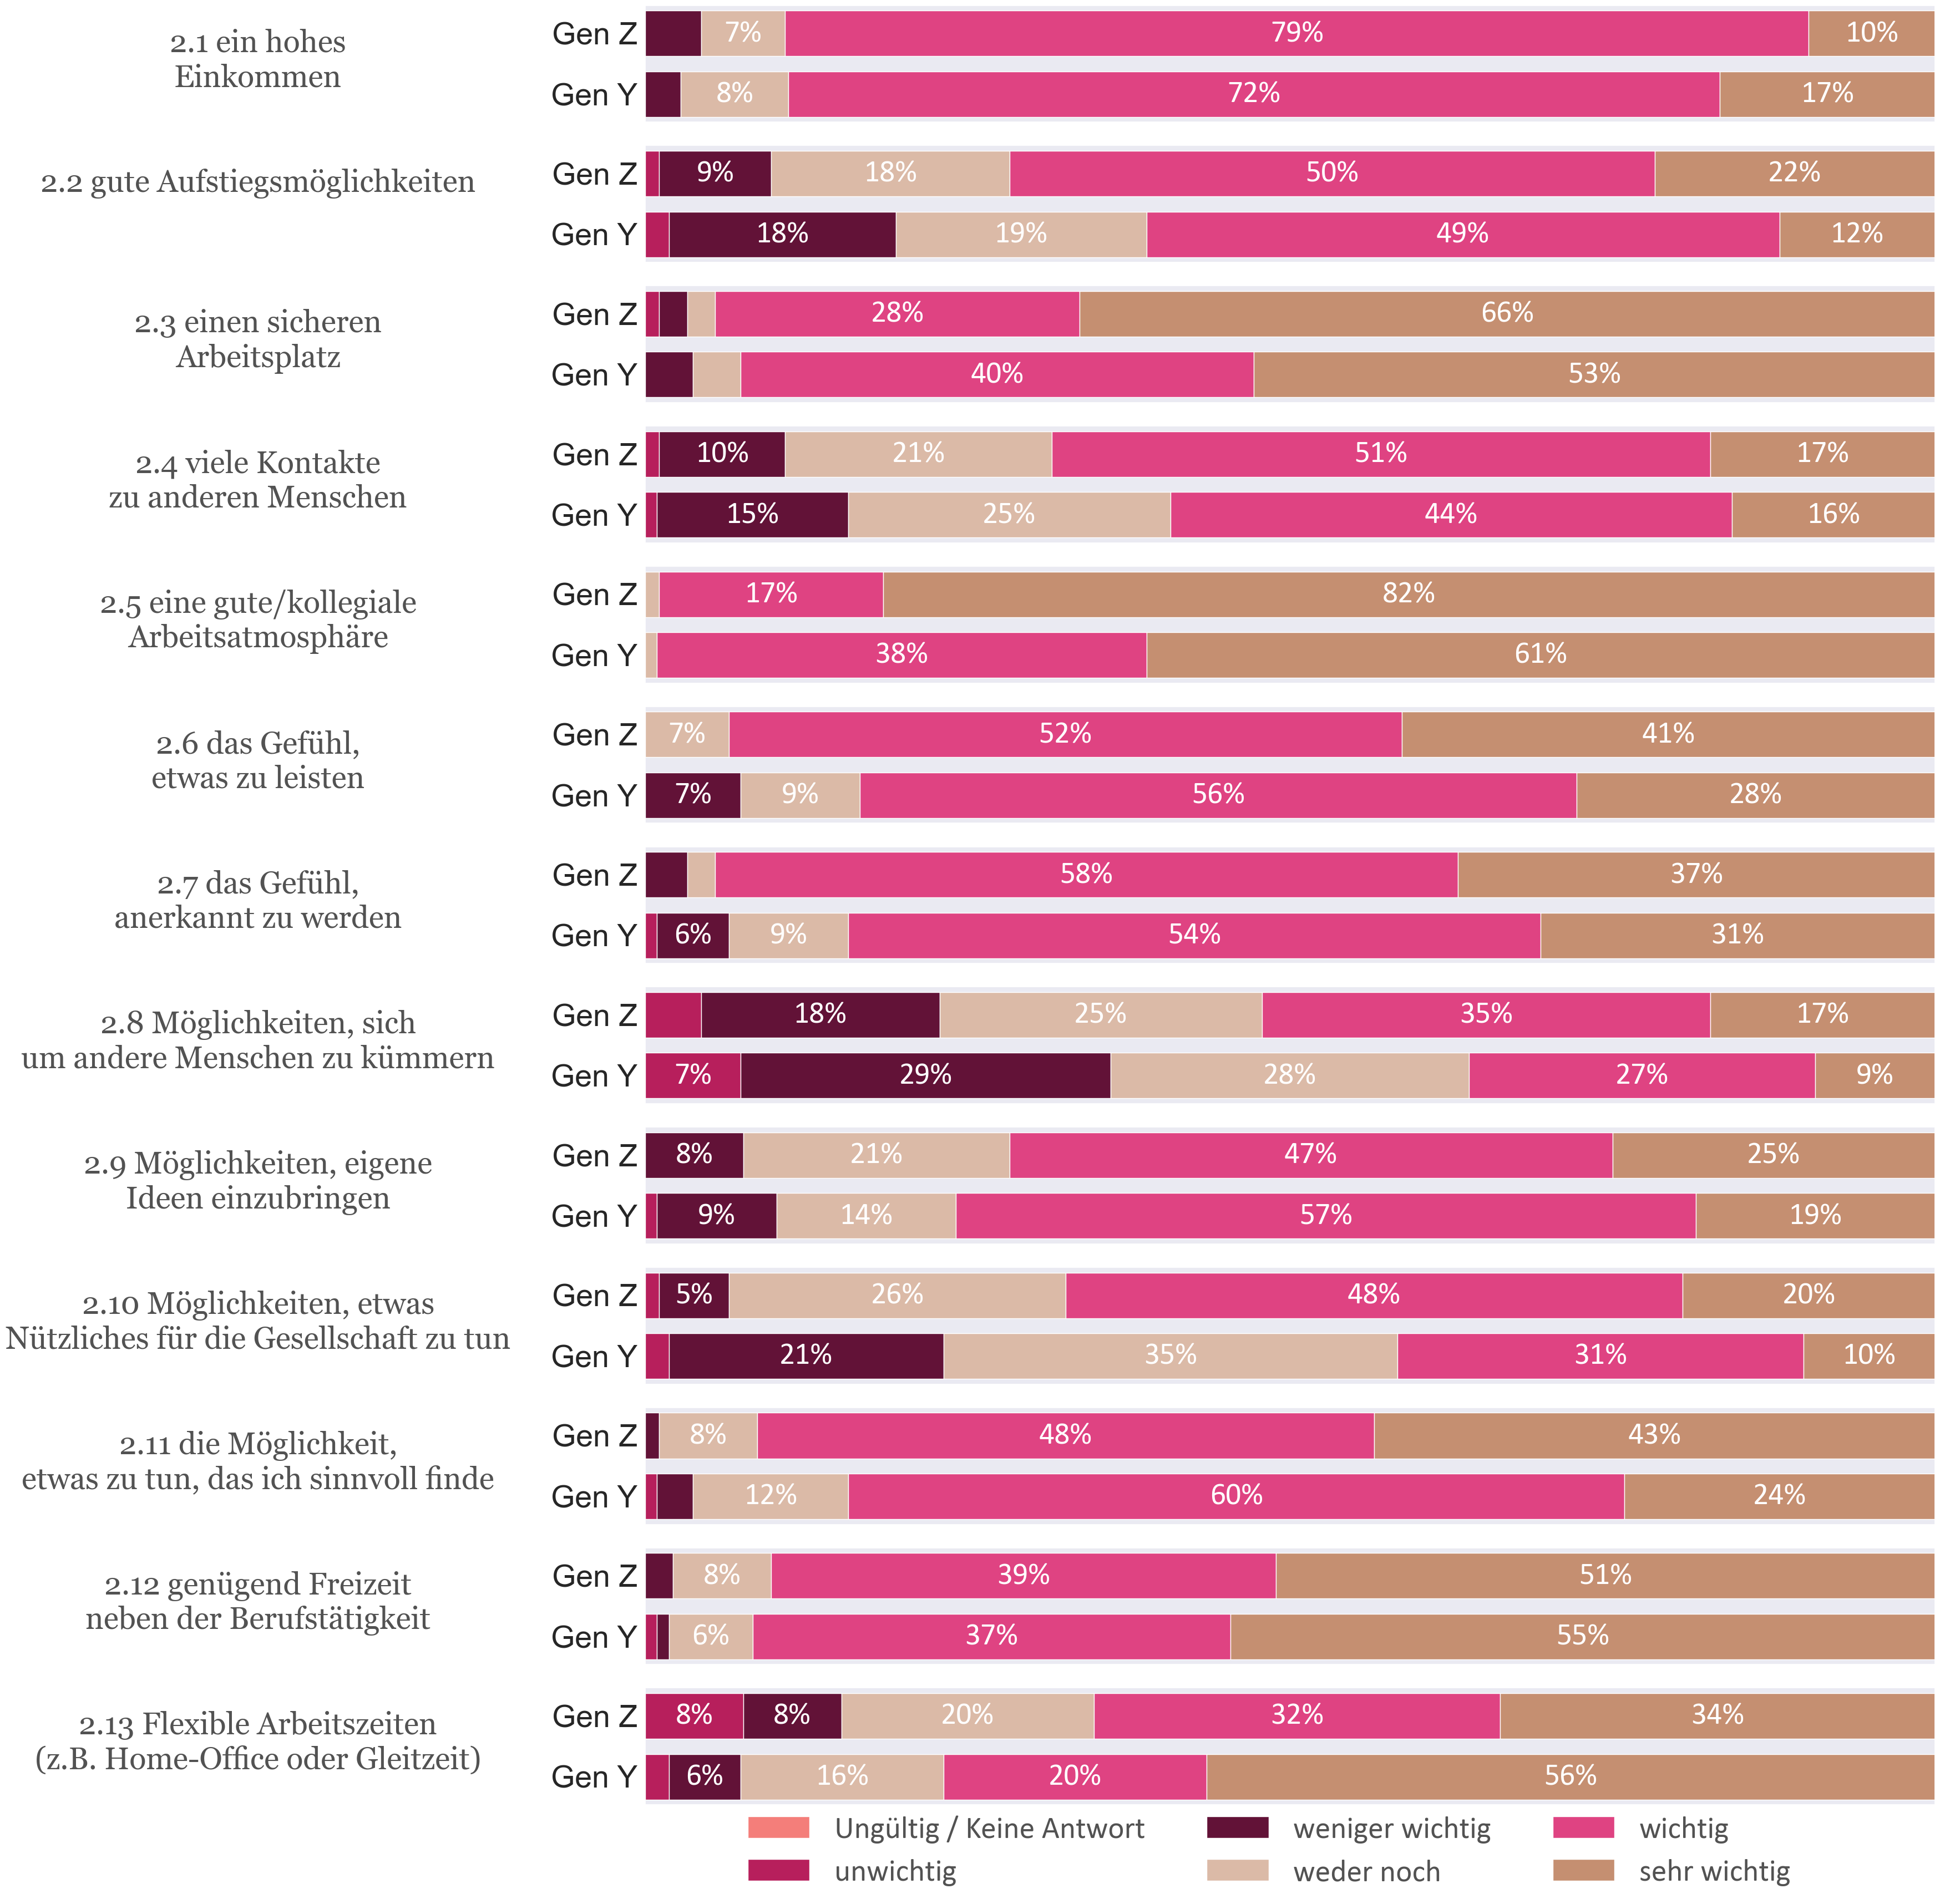

In [257]:
fig, axs = plt.subplots(nrows=len(erwartungen_ids), figsize=(30, 0.5))
sns.set()
colors = ['#f47e7a', '#b71f5c', '#621237', '#dbbaa7', '#df4382', '#c58f71']

for code, ax in zip(erwartungen_ids, axs.ravel()):
    count_df = get_count_df(df_yz, code)
    
    sns.set()

    left = np.zeros(2)
    y_pos = [0, 0.2]
    for col in count_df.columns:
        ax.barh(y_pos, count_df[col], height=0.15, label=col, left=left, color=colors[int(col)])
        left += count_df[col]
        
    
    # Adjust the subplot so that the title would fit
    plt.subplots_adjust(top=65)

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(40)
     
    
    ax.axes.get_xaxis().set_visible(False)
    
    ax.set_yticks(y_pos, labels=count_df.index)   
    ax.set_ylabel(add_new_line(get_question_text(code)), labelpad=0, fontsize=40, color=font_color, rotation=0, **csfont)
    ax.yaxis.set_label_coords(-0.3, 0.25)
    ax.set_xlim(0, 1)
    
    #ax.set_title(get_question_text(code), pad=20, fontsize=14, color=font_color, **csfont)
    
    for p in ax.patches:
        #print(p)
        width, height = p.get_width(), p.get_height()
        #print(width)
        x, y = p.get_xy() 
        if width > 0.05:
            ax.text(x+width/2, 
                    y+height/2, 
                    f"{width*100:.0f}%", 
                    horizontalalignment='center', 
                    verticalalignment='center',
                    color='white',
                    fontsize=40,
                    **hfont)
            
labels_handles = {
  label: handle for ax in fig.axes for handle, label in zip(*ax.get_legend_handles_labels())
}

legend = fig.legend(labels_handles.values(),
                    labels_handles.keys(),
                    bbox_to_anchor=(0., .90, 1., .502),
                    loc='lower center',
                    frameon=False, 
                    ncol=3, 
                    borderaxespad=-3.75,
                    prop={'size': 40, 'family':'Calibri'})

for text in legend.get_texts():
    text.set(text=get_answer_text(code,int(text.get_text())))
    plt.setp(text, color=font_color) # legend font color

   

#### 2.3.2 Darstellung Umfrageergebnisse - Merkmale des Arbeitgebers

['4.1', 'Größe', 'des', 'Unternehmens']
['4.2', 'Ruf', 'des', 'Unternehmens']
['4.3', 'Standort', 'des', 'Unternehmens']
['4.4', 'Bereitstellung', 'neuster', 'Technologien', 'am', 'Arbeitsplatz']
['4.5', 'Flache', 'Hierarchien', '(auf', 'Augenhöhe', 'miteinander', 'arbeiten)']
['4.6', 'Nachhaltigkeit\xa0', 'Corporate', 'Social', 'Responsibility', '*']


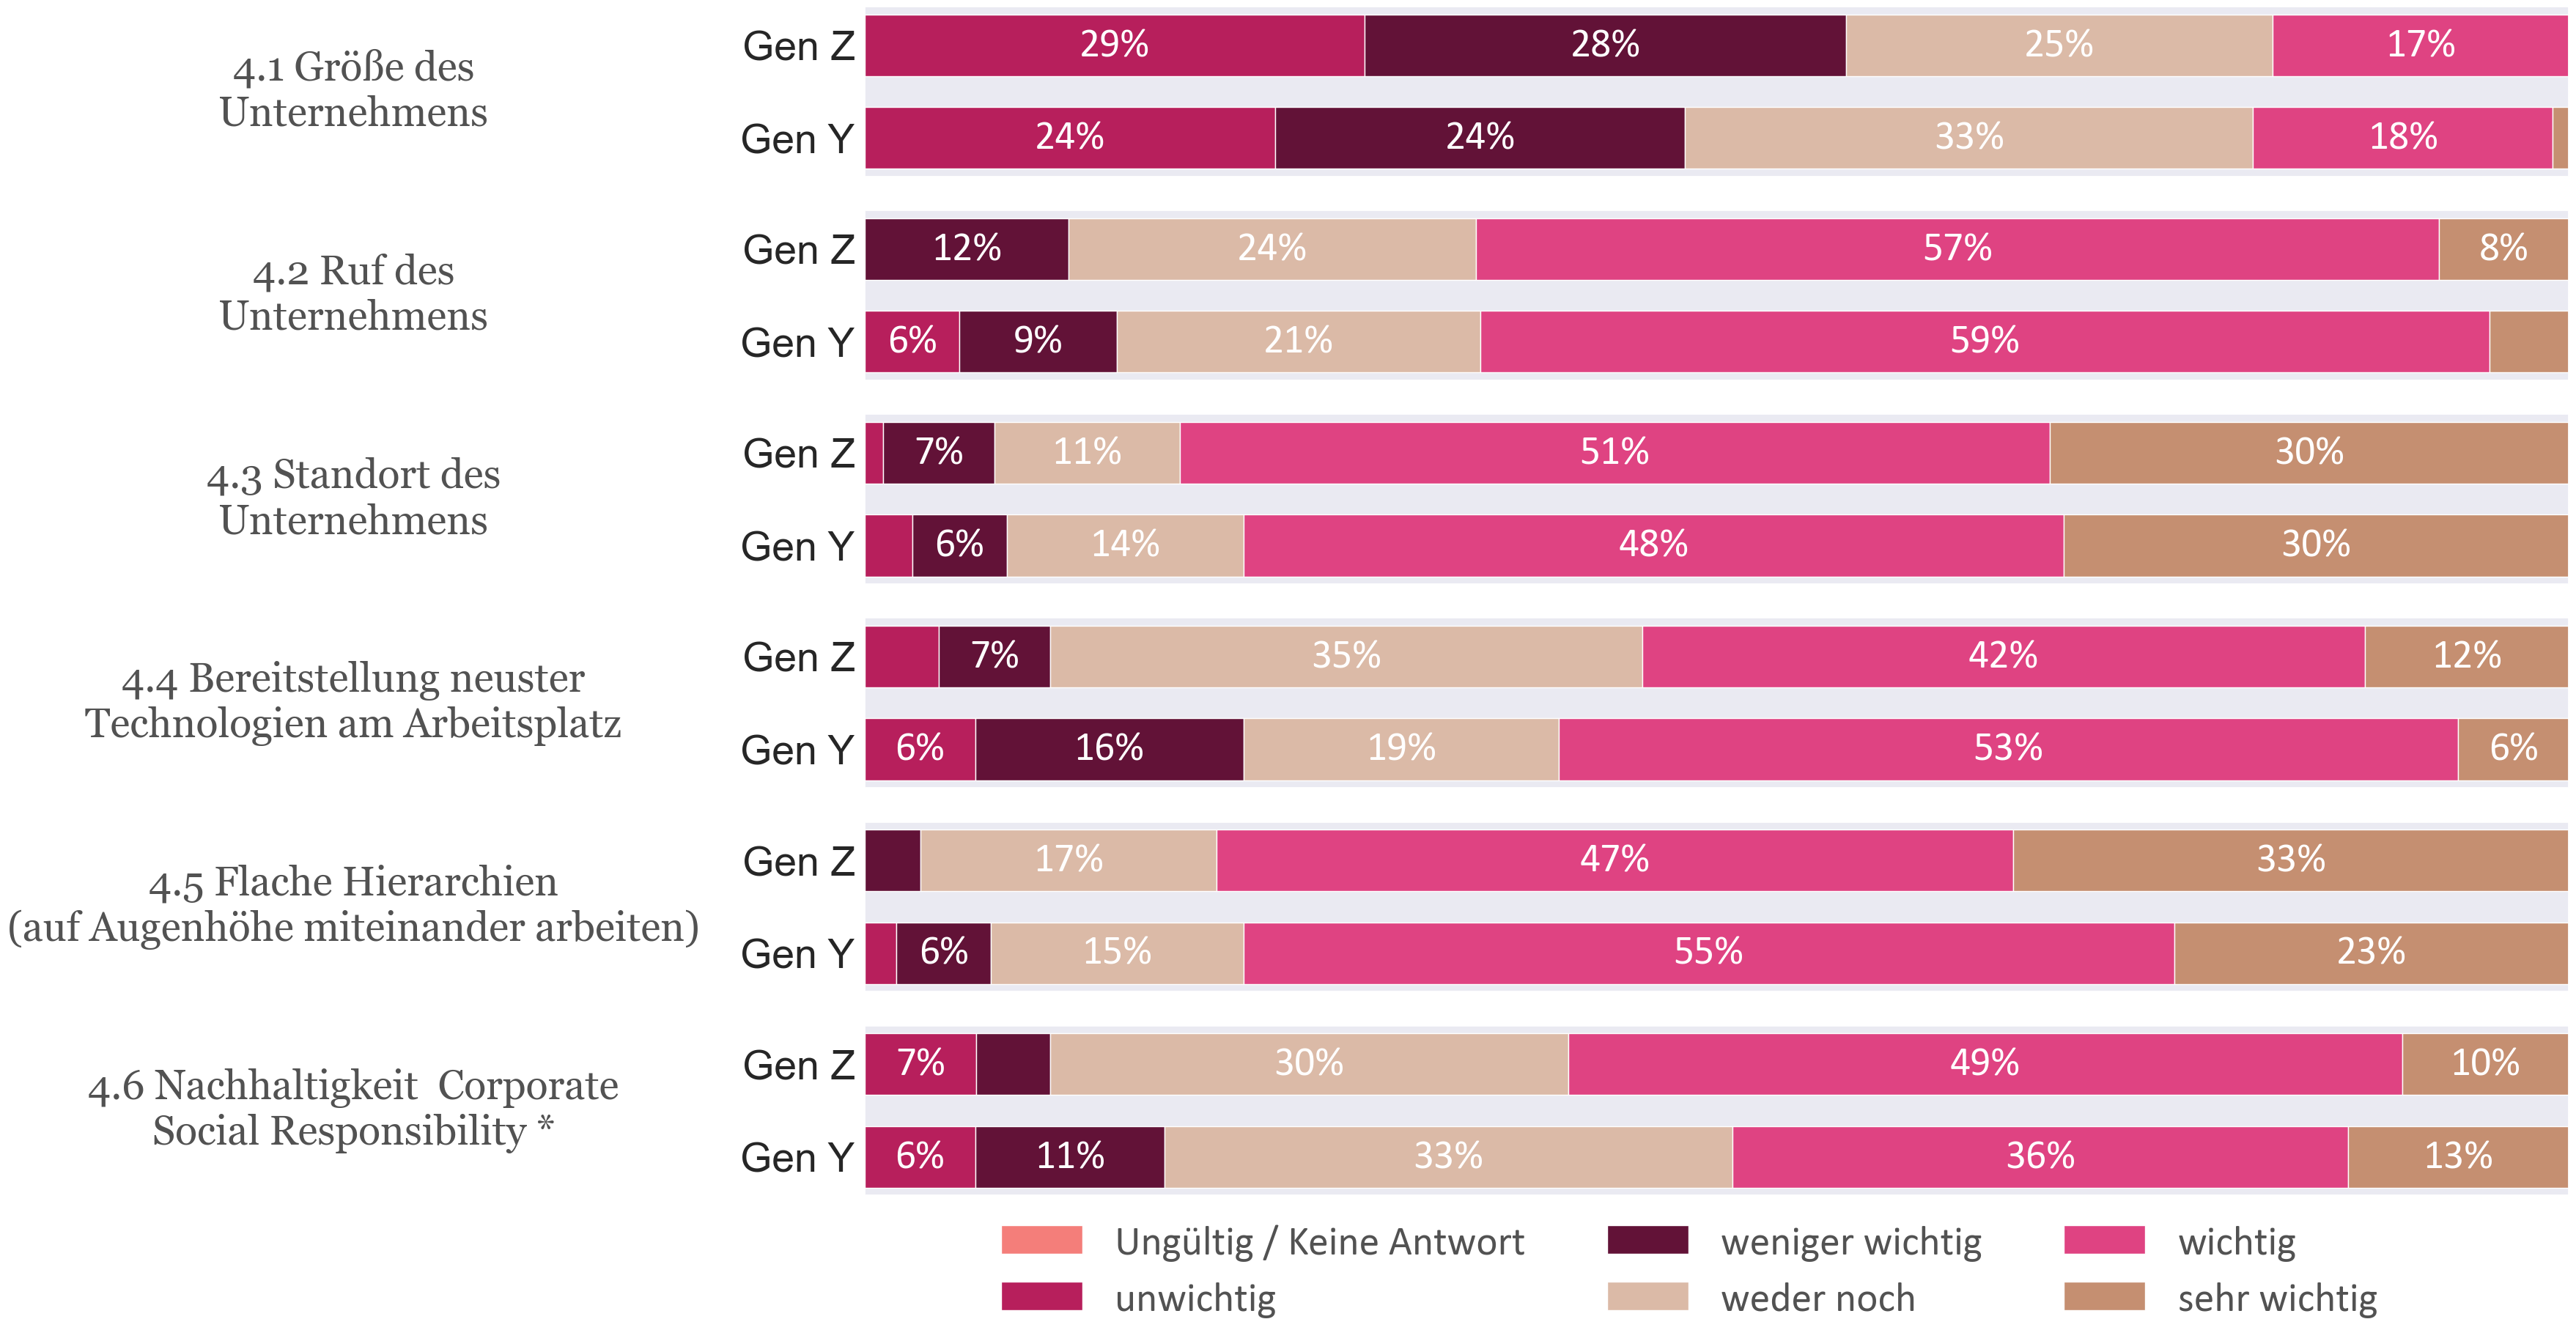

In [280]:
fig, axs = plt.subplots(nrows=len(ag_merkmale_ids), figsize=(30, 0.25))
sns.set()
colors = ['#f47e7a', '#b71f5c', '#621237', '#dbbaa7', '#df4382', '#c58f71']

for code, ax in zip(ag_merkmale_ids, axs.ravel()):
    count_df = get_count_df(df_yz, code)
    
    sns.set()

    left = np.zeros(2)
    y_pos = [0, 0.075]
    for col in count_df.columns:
        ax.barh(y_pos, count_df[col], height=0.05, label=col, left=left, color=colors[int(col)])
        left += count_df[col]
        
    
    # Adjust the subplot so that the title would fit
    plt.subplots_adjust(top=65)

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(40)
     
    
    ax.axes.get_xaxis().set_visible(False)
    
    ax.set_yticks(y_pos, labels=count_df.index)   
    ax.set_ylabel(add_new_line(get_question_text(code)), labelpad=0, fontsize=40, color=font_color, rotation=0, **csfont)
    ax.yaxis.set_label_coords(-0.3, 0.25)
    ax.set_xlim(0, 1)
    
    #ax.set_title(get_question_text(code), pad=20, fontsize=14, color=font_color, **csfont)
    
    for p in ax.patches:
        #print(p)
        width, height = p.get_width(), p.get_height()
        #print(width)
        x, y = p.get_xy() 
        if width > 0.05:
            ax.text(x+width/2, 
                    y+height/2, 
                    f"{width*100:.0f}%", 
                    horizontalalignment='center', 
                    verticalalignment='center',
                    color='white',
                    fontsize=40,
                    **hfont)
            
labels_handles = {
  label: handle for ax in fig.axes for handle, label in zip(*ax.get_legend_handles_labels())
}

legend = fig.legend(labels_handles.values(),
                    labels_handles.keys(),
                    bbox_to_anchor=(0., .90, 1., .502),
                    loc='lower center',
                    frameon=False, 
                    ncol=3, 
                    borderaxespad=-3.75,
                    prop={'size': 40, 'family':'Calibri'})

for text in legend.get_texts():
    text.set(text=get_answer_text(code,int(text.get_text())))
    plt.setp(text, color=font_color) # legend font color

   

#### 2.3.3 Darstellung Umfrageergebnisse -  Persönliche Wertvorstellungen

['5.3', 'Macht', 'und', 'Einﬂuss', 'haben']
['5.2', 'einen', 'hohen', 'Lebensstandard', 'haben']
['5.7', 'sich', 'und', 'seine', 'Bedürfnisse', 'gegen', 'andere', 'durchsetzen']
['5.19', 'viele', 'Kontakte', 'zu', 'anderen', 'Menschen', 'haben']


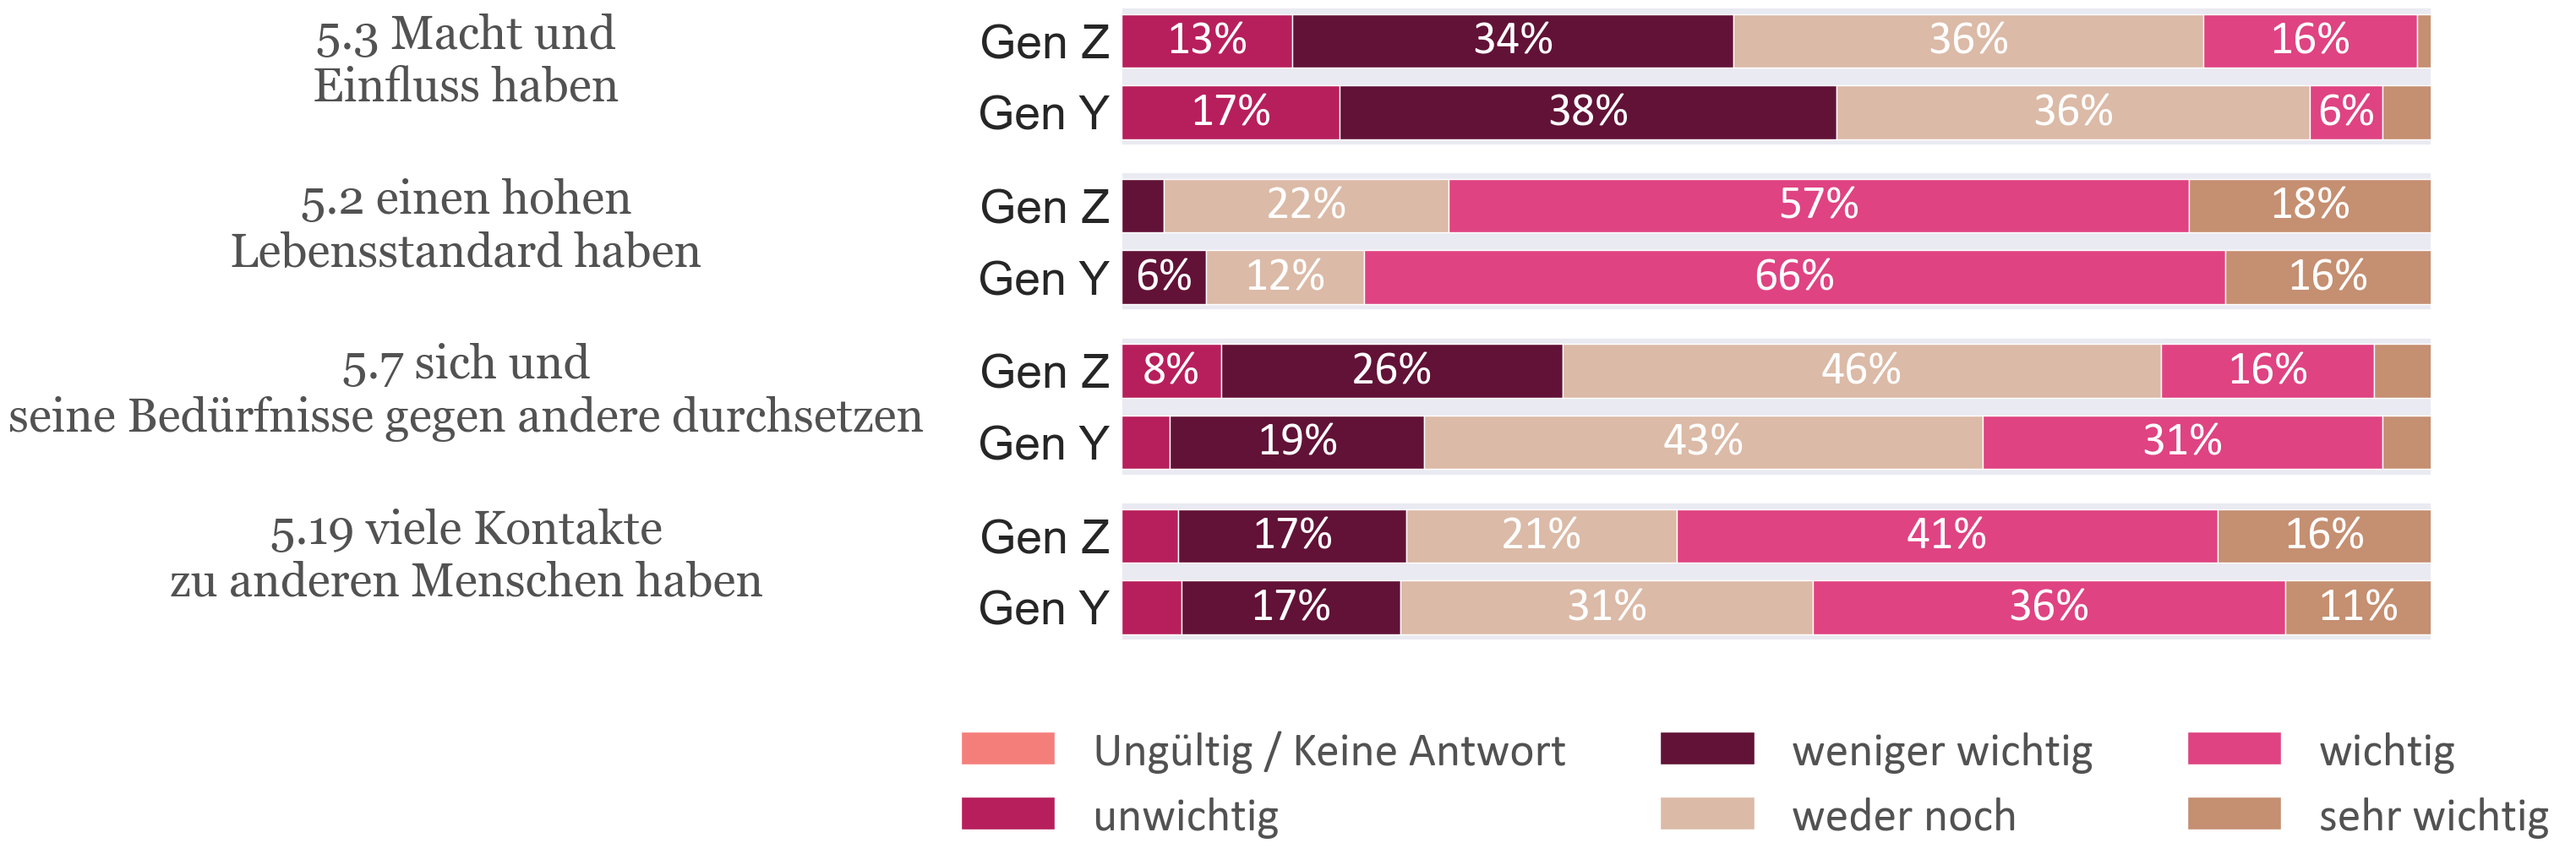

In [279]:
fig, axs = plt.subplots(nrows=len(macht_ids), figsize=(20, 0.1))
sns.set()

for code, ax in zip(macht_ids, axs.ravel()):
    count_df = get_count_df(df_yz, code)
    
    sns.set()
    
    left = np.zeros(2)
    y_pos = [0, 0.2]
    for col in count_df.columns:
        ax.barh(y_pos, count_df[col], height=0.15, label=col, left=left, color=colors[int(col)])
        left += count_df[col]

    #title = ax.set_title(get_question_text(code), pad=40, fontsize=24, color=font_color, **csfont)
    #title.set_position([0, 0])
    
    # Adjust the subplot so that the title would fit
    plt.subplots_adjust(top=75)

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(40)
    
    ax.axes.get_xaxis().set_visible(False)
    
    ax.set_yticks(y_pos, labels=count_df.index)   
    ax.set_ylabel(add_new_line(get_question_text(code)), labelpad=0, fontsize=40, color=font_color, rotation=0, **csfont)
    ax.yaxis.set_label_coords(-0.5, 0.25)
    ax.set_xlim(0, 1)
    
    #ax.set_title(get_question_text(code), pad=20, fontsize=14, color=font_color, **csfont)
    
    for p in ax.patches:
        #print(p)
        width, height = p.get_width(), p.get_height()
        #print(width)
        x, y = p.get_xy() 
        if width > 0.05:
            ax.text(x+width/2, 
                    y+height/2, 
                    f"{width*100:.0f}%", 
                    horizontalalignment='center', 
                    verticalalignment='center',
                    color='white',
                    fontsize=40,
                    **hfont)
            
labels_handles = {
  label: handle for ax in fig.axes for handle, label in zip(*ax.get_legend_handles_labels())
}

legend = fig.legend(labels_handles.values(),
                    labels_handles.keys(),
                    bbox_to_anchor=(0., .90, 1., .502),
                    loc='lower center',
                    frameon=False, 
                    ncol=3, 
                    borderaxespad=-4.75,
                    prop={'size': 40, 'family':'Calibri'})

for text in legend.get_texts():
    text.set(text=get_answer_text(code,int(text.get_text())))
    plt.setp(text, color=font_color) # legend font color
   

In [143]:
total = df_yz[gender_col].count()
total_y = 108 
total_z = 92

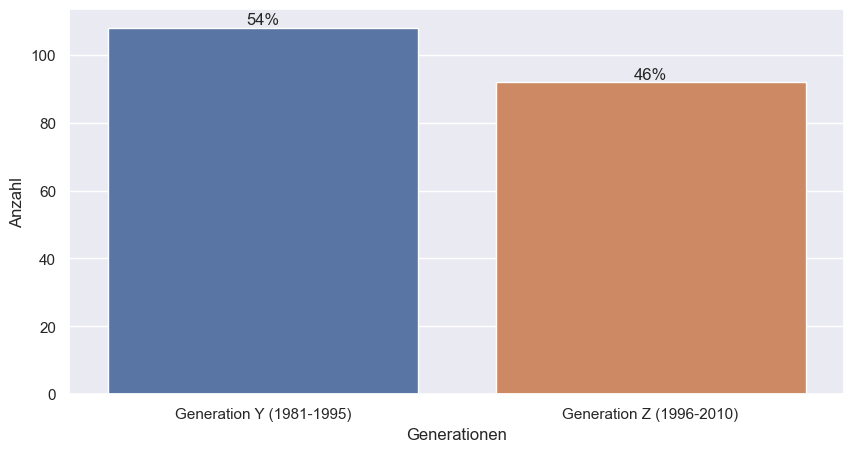

In [144]:
plt.figure(figsize=(10,5))
fig = sns.countplot(data=df_yz, x=generation_col)
plt.xlabel("Generationen")
fig.axes.set_xticklabels(labels=[get_answer_text(generation_col, x) for x in sorted(df_yz[generation_col].unique())])
plt.ylabel("Anzahl")
# add annotations
for c in fig.containers:
    fig.bar_label(c, fmt=lambda v: f'{(v/total)*100:0.0f}%')
plt.show(fig)

In [145]:
def plt_classes_bar(input_df: pd.DataFrame, col_code: str, title: str):
    plt.figure(figsize=(10,5))
    ax = sns.countplot(data=input_df, x=generation_col, hue=col_code)
    plt.xlabel("Generationen")
    ax.set_xticklabels(labels=[get_answer_text(generation_col, x) for x in sorted(input_df[generation_col].unique())])
    plt.ylabel("Anzahl")
    plt.title(title)
    plt.legend(labels=[get_answer_text(col_code, x) for x in sorted(input_df[col_code].unique())])

    for rect in ax.patches:
        height = rect.get_height()
        x, y = rect.get_xy() 
        if x < 0.6:
            tmp_total = total_y
        else:
            tmp_total = total_z
        ax.text(
        rect.get_x() + rect.get_width() / 2, height, f"{(height/tmp_total)*100:0.0f}%", ha="center", va="bottom"
        )
            
        #fig.bar_label(c, fmt=lambda v: f'{(v/total)*100:0.1f}%')
    plt.show(fig)

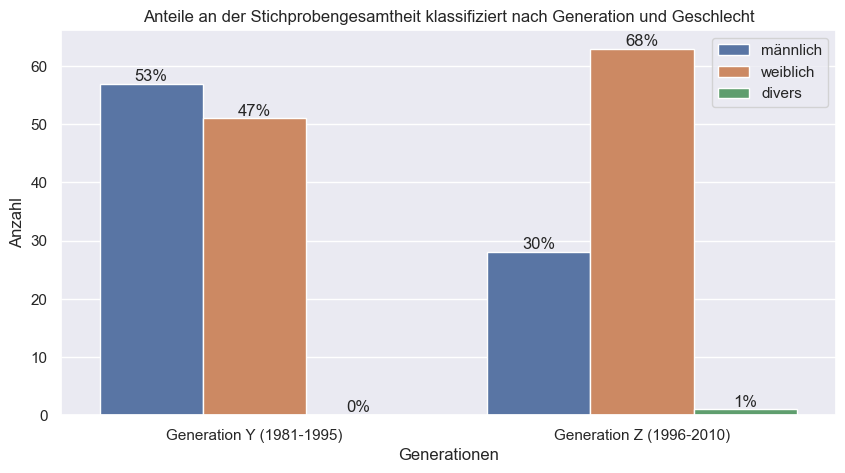

In [146]:
plt_classes_bar(df_yz, gender_col, "Anteile an der Stichprobengesamtheit klassifiziert nach Generation und Geschlecht")

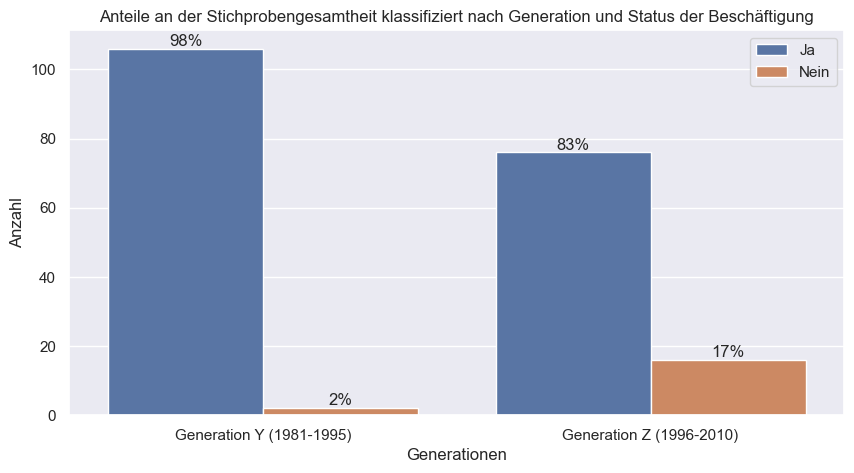

In [147]:
plt_classes_bar(df_yz, working_col, "Anteile an der Stichprobengesamtheit klassifiziert nach Generation und Status der Beschäftigung")

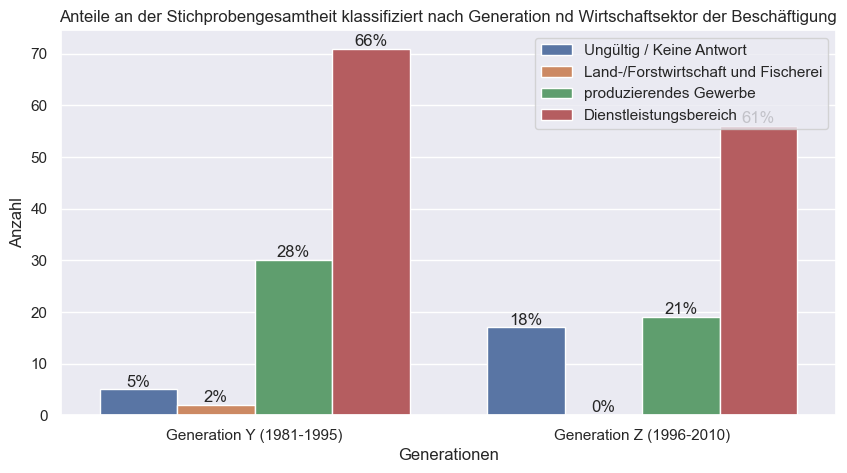

In [148]:
plt_classes_bar(df_yz, economic_sector_col, "Anteile an der Stichprobengesamtheit klassifiziert nach Generation nd Wirtschaftsektor der Beschäftigung")

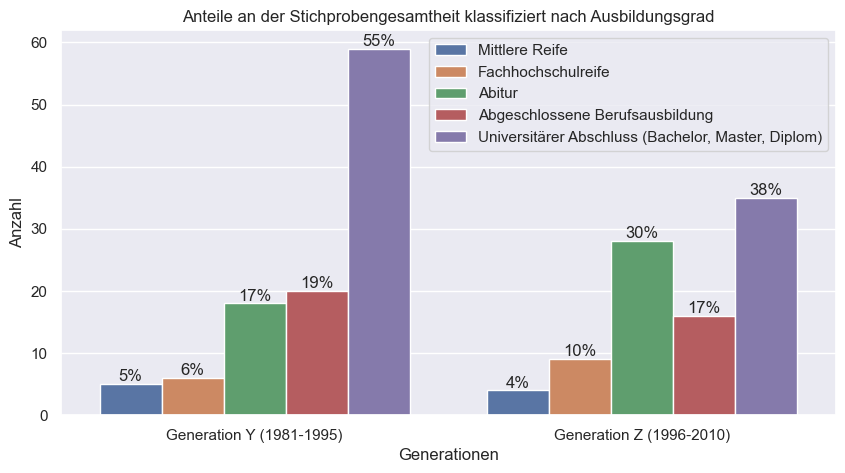

In [149]:
plt_classes_bar(df_yz, academic_col, "Anteile an der Stichprobengesamtheit klassifiziert nach Ausbildungsgrad")